# Developing Machine Learning Apps for Healthcare

In [1]:
#@title Run this to prepare our libraries and data! { display-mode: "form" } 

# networking
!pip -q install pyngrok

from pyngrok import ngrok

from __future__ import print_function
import json
import cv2

!pip install patool
import patoolib
import os
import gdown

import random

import codecs
import base64

import time
from multiprocessing import Pool

import glob
import numpy as np
from tqdm import tqdm
from google.colab.patches import cv2_imshow

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

!pip3 install psutil
import psutil

from sklearn.metrics import accuracy_score
from joblib import dump, load

!pip -q install streamlit
!pip -q install pyngrok

from pyngrok import ngrok

#ML
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.cluster import KMeans

import keras
from keras import backend as K
from tensorflow.keras.layers import *
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf

DATA_ROOT = '/content/data'
os.makedirs(DATA_ROOT, exist_ok=True)
max_samples = 3000

blood_slide_url = 'https://drive.google.com/uc?id=1lffxAG8gykh1dh1pCP34uRkH3XMwuNt-'
blood_slide_path = os.path.join(DATA_ROOT, 'blood_slide.jpg')
gdown.download(blood_slide_url, blood_slide_path, True)

malaria_imgs_url = 'https://drive.google.com/uc?id=12cmn17NPhhxkw8wWxIACnxRuvXpiQWnr'
malaria_imgs_path = os.path.join(DATA_ROOT, 'malaria_imgs.zip')
gdown.download(malaria_imgs_url, malaria_imgs_path, True)

if os.path.exists(os.path.join(DATA_ROOT, 'malaria_images')) == False:
  patoolib.extract_archive(os.path.join(DATA_ROOT, 'malaria_imgs.zip'), outdir=DATA_ROOT)

print("Downloaded Data")

u_malaria_img_paths = glob.glob('/content/data/malaria_images/Uninfected/*png')
p_malaria_img_paths = glob.glob('/content/data/malaria_images/Parasitized/*png')

NUM_SAMPLES = len(u_malaria_img_paths) + len(p_malaria_img_paths)

X_img = []
y_img = []

X_g_img = []

for i in tqdm(range(max_samples)):
  img = cv2.imread(u_malaria_img_paths[i])
  X_img.append(cv2.resize(img,(50,50)))

  gray_img = cv2.imread(u_malaria_img_paths[i],0)
  X_g_img.append(cv2.resize(gray_img,(50,50)))

  y_img.append(0)

for i in tqdm(range(max_samples)):
  img = cv2.imread(p_malaria_img_paths[i])
  X_img.append(cv2.resize(img,(50,50)))

  gray_img = cv2.imread(p_malaria_img_paths[i],0)
  X_g_img.append(cv2.resize(gray_img,(50,50)))

  y_img.append(1)

X_img = np.stack(X_img)
X_g_img = np.stack(X_g_img)

y_img = np.array(y_img)

blood_samples_dir = 'blood_samples'
if (os.path.exists(blood_samples_dir) == False):
  os.mkdir(blood_samples_dir)

for i, img in enumerate(X_img[2995:3005]):
  plt.imsave('test_img_{}.jpg'.format(i), img)
  
print("Created our X and y variables")


     |████████████████████████████████| 747kB 14.8MB/s 
     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 7.8MB 15.1MB/s 
     |████████████████████████████████| 112kB 60.0MB/s 
     |████████████████████████████████| 174kB 53.9MB/s 
     |████████████████████████████████| 4.2MB 53.2MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 122kB 63.3MB/s 
ERROR: ipykernel 6.0.1 has requirement ipython>=7.23.1, but you'll have ipython 5.5.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 6.0.1 which is incompatible.
patool: Extracting /content/data/malaria_imgs.zip ...
patool: running /usr/bin/7z x -o/content/data -- /content/data/malaria_imgs.zip


  2%|▏         | 54/3000 [00:00<00:05, 535.28it/s]

patool: ... /content/data/malaria_imgs.zip extracted to `/content/data'.
Downloaded Data


100%|██████████| 3000/3000 [00:03<00:00, 965.01it/s]


Created our X and y variables


In this notebook, we'll build a machine learning model to diagnose malaria and deploy our model to a mobile-friendly web app. 

**Discuss: Why is it important to deploy AI models to apps, especially in healthcare? Who could benefit?**

One huge benefit is that machine learning apps can quickly and cheaply screen people for diseases! Check out a few examples:
*  [Detecting early Parkinson's disease](https://parkinsonsnewstoday.com/2019/01/15/smartphone-app-identifies-early-symptoms-motor-disorders-study/) by analyzing finger-tapping
*  [Recognizing asymptomatic COVID-19](https://news.mit.edu/2020/covid-19-cough-cellphone-detection-1029) based on particular cough sounds
*  (Developed by a high-schooler!) [Screening for eye disease with computer vision](https://www.youtube.com/watch?v=kLx4ey4d8DQ) in parts of the world where there aren't enough doctors 

Because billions of people worldwide have smartphones, ML apps have the potential to get huge numbers of people diagnosed and treated!

Today, we'll build an app to help fight one of the world's most terrible diseases: malaria, which every year infects over 200 million people and kills more than 200,000 children. Our goal is to help healthcare workers in rural or developing areas diagnose malaria without expensive lab equipment. Our app will let a healthcare worker upload an image of blood cells under a microscope, and then use computer vision to detect the malaria parasite.

![](https://cdn1.sph.harvard.edu/wp-content/uploads/sites/21/2018/01/parasite.jpg)

**Discuss: What are the parts of the app that we'll need to build?**

We'll split our work into three parts:
*   Back-end: building a machine learning model to classify an image of blood cells 
*   Front end: making an easy-to-use, mobile-friendly website that lets users upload an image and outputs the answer
*   Connecting the front-end and back-end so the model can analyze the user's image

# Part 1: Malaria Diagnosis

Let's construct a machine learning model to diagnose malaria!

To start off, **take a look at our data**, which is stored in the `X_img` and `y_img` variables. (Hint: use `plt.imshow` if you want to see an image.) Can you spot evidence of malaria?



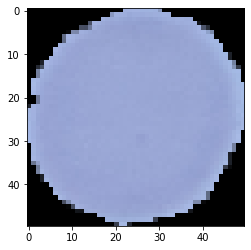

In [3]:
# YOUR CODE HERE
plt.imshow(X_img[4])

**Optional:** Let's try to visualize our entire dataset. It's tricky with high-dimensional data, but we can use a mathematical technique called Principal Component Analysis (PCA) to visualize it in 2D. 

**Discuss: What do you notice here? Does it look like it'll be easy to distinguish positive and negative examples?**

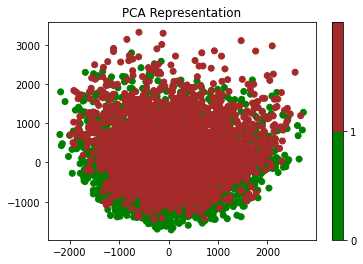

In [4]:
#@title Run this to perform and visualize PCA! { display-mode: "form" } 
pca = PCA(n_components=20)

X_img_reshaped = np.reshape(X_g_img,(X_g_img.shape[0],2500))
X_img_pca = pca.fit_transform(X_img_reshaped)

colors = ["green","brown"] # try editing the colors!
classes = [0,1]

plt.scatter(X_img_pca[:,0], X_img_pca[:,1], c=y_img, cmap=matplotlib.colors.ListedColormap(colors))
cb = plt.colorbar()
loc = np.arange(0,max(y_img),max(y_img)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(classes)
plt.title("PCA Representation")
plt.show()

#Training Our Model

Fingers crossed - let's train our ML model! To start simple, we'll use Scikit-learn. Of course, we could also try a CNN for this task in Keras!

Please:


*   Use `X_img_reshaped`, a flattened array that we can use in Scikit-learn
*   Perform a `train_test_split`
*   Train an `SVC` model (a Support Vector Machine classifier: this is a common though mathematically tricky algorithm.)
*   `score` the model to find our accuracy!



In [5]:
model = SVC()

#YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X_img_reshaped, y_img, test_size = 0.2)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6908333333333333

Nice - we've developed a machine learning method for identifying parasitized blood cells to help diagnose malaria! Of course, you can always come back later to make your model more accurate.

For now, let's save our model to a file so we can use it in an app.

In [6]:
dump(model, "model.joblib")

['model.joblib']

# Part 2: Creating a Healthcare App User Interface

Now, let's make a user interface for our malaria diagnosis app.

**Discuss: What elements should our web app include to be effective and easy to use?**

We'll build our app using [Streamlit](https://www.streamlit.io/), a new Python package designed for quickly building machine-learning web apps. This means we'll be able to write all our code right here in Colab - much trickier to do with classic web design tools like HTML and JavaScript!

We'll use a nifty Colab command, `%%writefile`, to write code directly to a Python file: `app.py`. To start with, let's create a super-basic web app with just a title.

In [39]:
%%writefile app.py
import streamlit as st
import numpy as np
import cv2
from joblib import dump, load

model = load("model.joblib" ) # loading up our saved model

st.title('Malaria Diagnosis') #Change the title here!
uploaded_file = st.file_uploader("Upload File")

if uploaded_file:
  file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
  
  image = cv2.imdecode(file_bytes, 1)
  small = cv2.resize(image, (50,50)) #YOUR CODE HERE: specify image, dimensions
  gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)
  re = np.reshape(gray, (1,2500))
  prediction = model.predict(re)
  st.write("Likelihood of malaria: " + str(prediction))
  if prediction < 1:
    st.header("Malaria negative")
  else:
    st.header("Malaria positive")
#Later: add more Streamlit code here

Overwriting app.py


Now, in three lines of code we can host our app on the Web! Run this block, then click the URL to access your webpage: it'll be accessible until you stop the code block. You can also check it out on your phone.

In [40]:
#Publish Web App (Run this again whenever you make changes)
public_url = ngrok.connect(port='80')
print (public_url)
!streamlit run --server.port 80 app.py >/dev/null

NgrokTunnel: "http://79f93fc0a663.ngrok.io" -> "http://localhost:80"
2021-07-04 15:39:00.124 Got an empty FileUploader widget_value. (We expect a list with at least one value in it.)
2021-07-04 15:39:08.481 Got an empty FileUploader widget_value. (We expect a list with at least one value in it.)


In [ ]:
#@title If you get an error above, run this to reinitialize Streamlit, then try again!
%%writefile ~/.streamlit/config.toml
[server]
port = 80

Now, you can customize your Streamlit user interface (UI)! 

Choose the elements you want from the toolbox below, then copy-paste them into the `%%writefile app.py` code above in whatever order you'd like to define your UI. Check out this [cheat sheet](https://share.streamlit.io/daniellewisdl/streamlit-cheat-sheet/app.py) for more.


In [ ]:
#Your Streamlit Toolbox!

"""
#Write text
st.write("text")

#Title
st.title('title')

#Header
st.header('header')

#Slider
value = st.slider('variable')

#Table
st.table(dataframe) #use a Pandas DataFrame

#Bar Chart (Example)
chart_data = pd.DataFrame([[45, 0, 0], [0, 32, 0], [0, 0, 35]],
     columns=["apples", "oranges", "pears"])
st.bar_chart(chart_data)

#Matplotlib Figure
st.pyplot(fig) #use a Matplotlib figure

#Image
st.image(image, caption='Image Caption')

#Button
pressed = st.button('Button Name')

#Checkbox
checked = st.checkbox('Checkbox Name')

#File Input
uploaded_file = st.file_uploader("Upload File")

if uploaded_file is not None:    
    pass #Do something here!

"""

Now take these Streamlit elements and design your interface for malaria diagnosis! Be sure to replace the placeholder values and variable names with your specifics in mind. 

Whenever you want to view your updated website, rewrite your code into `app.py` and then host your web app again.

#Part 3: Connecting Our App and Model
Now we've got a beautiful web app, but it can't do anything yet! Let's connect our app to our model, so that the user can upload an image of a blood slide, the model will analyze the image, and finally the app will display the diagnosis result with some text. 


We'll start off by writing our image processing code here in Colab. Although it won't execute here, it'll be easier to visualize the steps. Later, we'll add it to our Streamlit code.

First things first: we need to check if an image has been uploaded! **What code from your Streamlit Toolbox will make sure that we only start analyzing an image once it's uploaded?**



In [ ]:
#Your Code Here

Once we get an image, we'll convert it to a Numpy array like this:

In [ ]:
#Remember, this won't run here!
file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
image = cv2.imdecode(file_bytes, 1)

Next, we'll convert `image` into a 50 x 50 grayscale image: we'll convert it to grayscale and then to the new dimensions. Please complete the code:


In [ ]:
small = cv2.resize() #YOUR CODE HERE: specify image, dimensions
gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)

Next up, you'll use the `np.reshape()` function to flatten our image into a 1x2500 array and `model.predict()` to classify it.

In [ ]:
#Your Code Here

Based on the predicted output, you'll write a message to the user to tell them their results! You can write text with  `st.write()`.

In [ ]:
#Your Code Here

Excellent - now we're ready! Please paste the code above into your Streamlit code in the right order, and check out your finished website!

If you want images to test it out on, you can download 5 non-malaria and 5 malaria images from the Files tab on the left-hand side. 

#Discussion: Ethics
Now you know how to quickly deploy an ML model, and you can share any models you build using Streamlit web apps! You can also deploy your apps permanently using solutions like Heroku.

But especially in healthcare, it's not always clear that deploying a machine learning app is ethically the right thing to do. **Discuss:**


*   How could your app help people? How could you get people to use your app?
*   What could go wrong if your app makes mistakes, or if people use your app instead of consulting an expert?
*   How confident must you be in your app's accuracy before you deploy it? How can you make sure your app works well for different people in different circumstances? 
*   What information should you include on your page so users can make good decisions about using your app?

